In [1]:
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from pyproj import Proj
from sklearn.neighbors import RadiusNeighborsRegressor, KDTree
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# get raw data

dd = pd.read_csv("data/train.csv")

In [3]:
minlat,minlon = dd.min()[["lat","lon"]]
maxlat,maxlon = dd.max()[["lat","lon"]]
print minlat,minlon,maxlat,maxlon

42.2555997 -71.182802 42.43517 -70.97583


In [4]:
# add stateplane projection features
# the projection is in meters, and has the same spatial scale in the x and y dimensions

pj = Proj(init="epsg:2805")
x,y = pj(dd["lon"].values,dd["lat"].values)
dd["x"] = x
dd["y"] = y

In [5]:
# add month ordinal feature

dd["monthord"] = dd.year*12 + dd.month

In [6]:
# add price per bedroom feature

dd["ppb"] = dd.price/(dd.bedrooms+1)

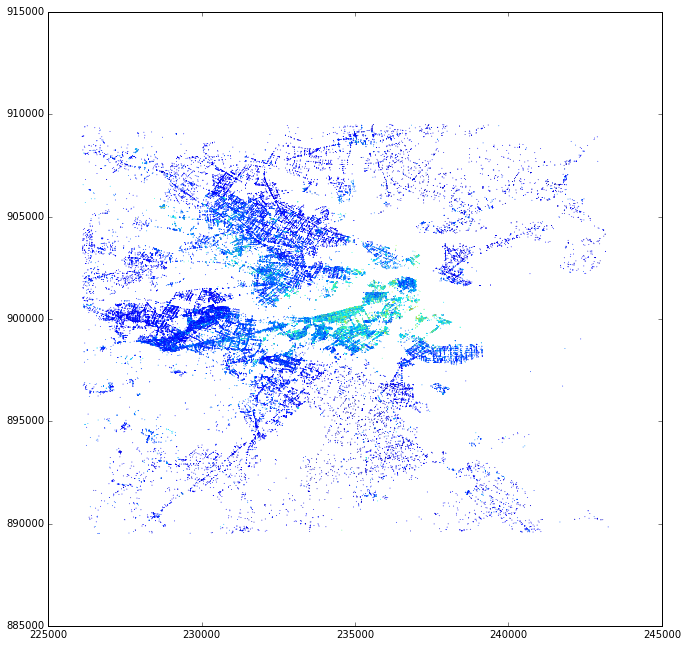

In [23]:
# let's give it a look-see

plt.figure(figsize=(11,11))
plt.scatter(dd.x.values,dd.y.values, c=dd.ppb.values,s=0.8,linewidth=0)

##A very simple nearest neighbor regression

In [11]:
X = dd[["x","y","bedrooms"]]*[1,1,10000] #make bedrooms important, 
y = dd["price"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0)

clf = KNeighborsRegressor(n_neighbors=7) # found by 10-fold cross-validation
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)

0.853775898177


##A very simple decision forest regression

In [12]:
from sklearn.ensemble import RandomForestRegressor

X = dd[["x","y","bedrooms","monthord"]]
y = dd["price"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0)

clf = RandomForestRegressor(n_estimators=300,n_jobs=-1)
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)


0.873433064861


In [13]:
X = dd[["x","y","bedrooms"]]
y = dd["price"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0)

clf = RandomForestRegressor(n_estimators=300,n_jobs=-1)
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)

0.854819174229


It looks like month helps a little, but not a lot.

##Nearest neighbor with month

In [14]:
X = dd[["x","y","bedrooms","monthord"]]*[1,1,10000,6]
y = dd["price"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0)

clf = KNeighborsRegressor(n_neighbors=7) # found by 10-fold cross-validation
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)

0.856713725046


##Nearest neighbor with distance weighting

In [15]:
X = dd[["x","y","bedrooms","monthord"]]*[1,1,10000,6]
y = dd["price"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0)

clf = KNeighborsRegressor(n_neighbors=9,weights="distance")
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)

0.870072010427


Just as good as the random forest!

##Special distance weight function

In [16]:
X = dd[["x","y","bedrooms","monthord"]]*[1,1,10000,6]
y = dd["price"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0)

clf = KNeighborsRegressor(n_neighbors=17,weights=lambda x:1/(x**2+500))
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)

0.871271303333


In [17]:
#Get score from k-fold cross-validation

clf = KNeighborsRegressor(n_neighbors=15,weights=lambda x:1/(x**2+200))

X = dd[["x","y","bedrooms","monthord"]]*[1,1,15000,15]
y = dd["price"]

scores = []
nfolds = 10
for i, (train_index, test_index) in enumerate( cross_validation.KFold(len(X),nfolds) ):
    print "%d/%d"%(i+1,nfolds)

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    scores.append( clf.score(X_test,y_test) )
print np.mean( scores )

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10
0.871846468017


##Predict price-per-room

In [24]:
X = dd[["x","y","monthord"]]*[1,1,6]
y = dd["ppb"]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0)

clf = KNeighborsRegressor(n_neighbors=30,weights=lambda x:1/(x**2+500))
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)

0.62461656377


Boy, that doesn't work well at all.

##Visualize the winner!

In [6]:
import shapefile
sf = shapefile.Reader("mapdata/borders")
borders = sf.shapes()

In [7]:
clf = KNeighborsRegressor(n_neighbors=15,weights=lambda x:1/(x**2+200))

X = dd[["x","y","bedrooms","monthord"]]*[1,1,15000,15]
y = dd["price"]

clf.fit(X,y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=15, p=2,
          weights=<function <lambda> at 0x1051c98c0>)

In [8]:
plt.ioff()

N = 400
dpi = 150
res = 800
figwidth = res/dpi

bedrooms = 3
monthord = 2014*12+0

xmin,ymin = dd.min()[["x","y"]]
xmax,ymax = dd.max()[["x","y"]]

xs = np.linspace(xmin,xmax,N)
ys = np.linspace(ymin,ymax,N)

xx, yy = [x.ravel() for x in np.meshgrid(xs,ys)]

grid_dd = pd.DataFrame.from_items((("x",xx),("y",yy),("bedrooms",bedrooms),("monthord",monthord)))
prices = clf.predict( grid_dd*[1,1,15000,15] )

fig = plt.figure(figsize=(figwidth,figwidth),dpi=dpi,frameon=False)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

cs = plt.contourf(xs,ys,prices.reshape((N,N)),levels=range(0,6500,500))
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
#plt.gca().axis('off')
#plt.scatter(dd.x,dd.y,c="black",s=0.3,linewidth=0)

year = int(monthord/12)
month = int(monthord%12)
day = int((monthord - (12*year+month))*31)
plt.text(0.95, 0.05,'%d/%02d/%02d'%(year,month+1,day+1), horizontalalignment='right', verticalalignment='bottom', transform=plt.gca().transAxes, fontsize=14)

bedtext = "bedroom" if bedrooms==1 else "bedrooms"
plt.text(0.5, 0.05,'%s %s'%(bedrooms,bedtext), horizontalalignment='center', verticalalignment='bottom', transform=plt.gca().transAxes, fontsize=14)

# create a legend for the contour set
artists, labels = cs.legend_elements()
labels = map(str, range(500,6500,500))
plt.legend(artists, labels, handleheight=1, fontsize=7)

for border in borders:
    borderx,bordery = np.array( border.points ).T
    plt.plot(borderx,bordery,color="black",linewidth=0.2)

with open('heatmap.png', 'w') as outfile:
    fig.canvas.print_png(outfile)

#plt.close(fig) #comment out if you want to suppress display in ipython

/Library/Python/2.7/site-packages/matplotlib-override/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [11]:
print type(fig.canvas)

<class 'matplotlib.backends.backend_agg.FigureCanvasAgg'>
